### Introduction

Aim of this project
- Start with an orginal playlist and create 2 new playlists based on the original playlist
- Store the new playlists automatically in my account
- Listen to the new playlists and decide which one is better

Approaches:
- Nearest: build our own - based on similar artists, their top tracks and a simple algo to pick the nearest matches
- Spreco: get Spotify's recommendations - the boring (but probably better) option

In [1]:
# import basic packages
import os
import pandas as pd
import matplotlib.pyplot as plt

### Connect to Spotipy

In order to connect to the Spotify API we will use the Authorization Code Flow. The credentials are stored locally in a text file.

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

In [3]:
def get_creds():
    ''' Users credentials can be stored in creds.txt file (same folder as Notebook)'''
    f = open("creds.txt", 'r')
    if f.mode == 'r':
        lines = f.readlines()
        username = lines[0].rstrip('\n')
        client_id = lines[1].rstrip('\n')
        client_secret = lines[2].rstrip('\n')
    return username, client_id, client_secret

In [4]:
def get_token(scope=None):
    '''
    To support the Authorization Code Flow Spotipy provides a utility method "util".
    This creates a token while allowing the user to set the scope of using the api.
    Info on scope: https://developer.spotify.com/web-api/using-scopes/
    
    '''        
    redirect_uri = 'http://example.com/callback/'
    
    try:
        try:
            username, client_id, client_secret = get_creds()
        
        except:
            username = raw_input('user=')
            client_id = raw_input('id=')
            client_secret = raw_input('secret=')
        
        token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)
    
    except:  # cache file for user already exists
        os.remove('.cache-'+username)
        token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

    return token

In [5]:
# connect
token = get_token(scope='playlist-modify-private')
sp = spotipy.Spotify(auth=token)

### Analyze original playlist

We select playlist to start with (=original playlist). We want to get all the artists, tracks and audio features of each track.

In [6]:
# get all playlists from user with id's
all_playlists = sp.user_playlists(user='bramvcamp').get('items')
lst_all = []
for elem in all_playlists:
    lst_all.append([elem['name'], elem['id']])
df_all = pd.DataFrame(lst_all, columns=['name','id'])
print df_all[:10]

                                                name                      id
0                              Indie Cindy - Nearest  2C2F3C794ivpgjHrgJdSHy
1                               Indie Cindy - Spreco  2pOUfGueVMwes5D2s1uzoE
2                          Energetic Run 160-165 BPM  37i9dQZF1DWT6anPZiHuxz
3                                        Pumpin iron  1W78mhA59hwyEFBuvEAbg6
4                                GOTG movie playlist  6WcxoUYAOBxBxuIMLKkcIM
5                                      70s Road Trip  37i9dQZF1DWWiDhnQ2IIru
6                                        Arbun tunes  4FOcibY3Pp6tIHWLouWFYz
7  Max Richter – Recomposed By Max Richter: Vival...  7imIhhHQIpsK260DFsjkGl
8                                           Easy 60s  37i9dQZF1DWZWYUuTGjjhE
9                                            The set  3YCQJp4sh461rOvXdtaB13


In [7]:
# create playlist obj
orginal_playlist_name = 'Indie Cindy'
orginal_playlist_id = df_all['id'][df_all.name==orginal_playlist_name].iloc[0]
original_playlist = sp.user_playlist(user='bramvcamp', playlist_id=orginal_playlist_id)

In [8]:
# get all artists from playlist
lst_original_artists = []
lst_original_tracks = []

for track in original_playlist['tracks']['items']:
    artist_id = track['track']['artists'][0]['id']
    track_id = track['track']['id']
    lst_original_artists.append(artist_id)
    lst_original_tracks.append(track_id)
    
lst_original_artists = list(set(lst_original_artists))
lst_original_tracks = list(set(lst_original_tracks))
print "{} unique artists in original playlist".format(len(lst_original_artists))

6 unique artists in original playlist


In [9]:
# analyse original playlist
lst_analysis_original = []
lst_use = ['energy','liveness','tempo','speechiness','acousticness','instrumentalness','danceability']

for track_id in lst_original_tracks:
    audio_feats = sp.audio_features([track_id])[0]
    lst_feats = [audio_feats.get(x) for x in lst_use]
    lst_analysis_original.append(lst_feats)

df_analysis_original = pd.DataFrame(lst_analysis_original, columns=lst_use, index=lst_original_tracks)
print df_analysis_original.head()

                        energy  liveness    tempo  speechiness  acousticness  \
4c9WmjVlQMr0s1IjbYO52Z   0.744     0.466  128.047       0.0368        0.0319   
6vTtMyCg96xwpoIBws9K0Q   0.897     0.116  150.185       0.0542        0.0276   
5dKBaysNJtfpyNTRa5lqDb   0.821     0.153  174.923       0.0539        0.0102   
7BHPGtpuuWWsvE7cCaMuEU   0.808     0.149  100.304       0.0892        0.0759   
53L6A3I9vf7rgEZnMzx54E   0.931     0.246  104.050       0.0469        0.0025   

                        instrumentalness  danceability  
4c9WmjVlQMr0s1IjbYO52Z          0.000458         0.639  
6vTtMyCg96xwpoIBws9K0Q          0.650000         0.291  
5dKBaysNJtfpyNTRa5lqDb          0.043800         0.551  
7BHPGtpuuWWsvE7cCaMuEU          0.000000         0.391  
53L6A3I9vf7rgEZnMzx54E          0.078300         0.495  


### Create database of top tracks from similar artist

Now we'll use the API to get a list of artists which are similar (but not the same) in comparison to the artists in from the original playlist. Next, we'll select a number of their (top) tracks and their audio features. 

In [10]:
# find similar artists
lst_out = []
lst_related_artists = []
top_n_artist = 3  # we take the top n artists

for artist_id in lst_original_artists:
    artist = sp.artist(artist_id)
    artist_name = artist.get('name')
    related = sp.artist_related_artists(artist['id'])
    related_artists = related.get('artists')
    
    for related_artist in related_artists[:top_n_artist]:
        if related_artist['id'] not in lst_original_artists+lst_related_artists:
            lst_related_artists.append(related_artist['id'])
            lst_out.append([artist_id, artist_name, related_artist['id'], related_artist['name']])

df_related = pd.DataFrame(lst_out, columns=['original_id', 'original_name', 'related_id', 'related_name'])
print "{} similar artists found".format(len(lst_related_artists))
print df_related[['original_name','related_name']]

18 similar artists found
      original_name              related_name
0         The Kooks                Razorlight
1         The Kooks            The Libertines
2         The Kooks               The Wombats
3   Vampire Weekend                Ra Ra Riot
4   Vampire Weekend             Local Natives
5   Vampire Weekend                 The Shins
6       Joe Goddard                WhoMadeWho
7       Joe Goddard                    Pional
8       Joe Goddard              John Talabot
9             Foals                  Blossoms
10            Foals                Wolf Alice
11            Foals             The Maccabees
12    Django Django     Everything Everything
13    Django Django               Wild Beasts
14    Django Django                   Teleman
15      Tame Impala  Unknown Mortal Orchestra
16      Tame Impala                      Pond
17      Tame Impala               Real Estate


In [11]:
# get top n tracks for each artist
lst_new = []
top_n_tracks = 10

for artist in lst_related_artists:
    counter = 0
    tracks = sp.artist_top_tracks(artist, country='NL')
    tracks = tracks.get('tracks')
    
    for track in tracks:
        if counter < top_n_tracks:
            lst_new.append(track.get('id'))
            counter +=1
        else:
            break
print "{} tracks found".format(len(lst_new))

180 tracks found


In [12]:
# analyse new tracks
lst_analysis_new = []
lst_use = ['energy','liveness','tempo','speechiness','acousticness','instrumentalness','danceability']

for track_id in lst_new:
    audio_feats = sp.audio_features([track_id])[0]
    lst_feats = [audio_feats.get(x) for x in lst_use]
    lst_analysis_new.append(lst_feats)

df_analysis_new = pd.DataFrame(lst_analysis_new, columns=lst_use, index=lst_new)

### Find which of the new tracks fit best to original playlist

We created a fairly large database with new tracks. Now we only want to keep those tracks which are similar (=nearest) to the tracks in the original playlist - here we'll use the data from the audio analysis.

Hereby we'll end up with our new playlist which we'll analyze in the end to see how "similar" our new playlist is in comparison to the original playlist.

In [13]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [14]:
knn = NearestNeighbors(n_neighbors=5)
X_original = np.array(df_analysis_original)
X_new = np.array(df_analysis_new)
knn.fit(X_new)
lst_ix = knn.kneighbors(X_original, n_neighbors=1, return_distance=False)

In [15]:
# flatten list of lists
lst_new_ix = []
for lst in lst_ix: 
    for ix in lst:
        lst_new_ix.append(ix)
        
lst_nearest_tracks = [lst_new[i] for i in lst_new_ix]
print "nr of original tracks:", len(lst_original_tracks)
print "nr of nearest tracks:", len(lst_nearest_tracks)

nr of original tracks: 8
nr of nearest tracks: 8


In [16]:
# analyse nearest tracks
lst_analysis_nearest = []
lst_use = ['energy','liveness','tempo','speechiness','acousticness','danceability']

for track_id in lst_nearest_tracks:
    audio_feats = sp.audio_features([track_id])[0]
    lst_feats = [audio_feats.get(x) for x in lst_use]
    lst_analysis_nearest.append(lst_feats)

df_analysis_nearest = pd.DataFrame(lst_analysis_nearest, columns=lst_use, index=lst_nearest_tracks)
print df_analysis_nearest.head()

                        energy  liveness    tempo  speechiness  acousticness  \
5cCRoO5AGNmZp3S1HOvoH6   0.902    0.1580  128.020       0.0647      0.000228   
0ZwlxoHAnvkCRjsOrHAleU   0.875    0.1690  150.782       0.0301      0.029900   
5EkRiZl4BY7carwe6ikHF3   0.885    0.0986  175.001       0.1390      0.014500   
6iFwcRQsGBmW4paSWz5phj   0.806    0.6940  100.157       0.0402      0.000264   
1H4mV1lgrNBUjZgRjjP1nu   0.782    0.2840  104.104       0.0273      0.058100   

                        danceability  
5cCRoO5AGNmZp3S1HOvoH6         0.443  
0ZwlxoHAnvkCRjsOrHAleU         0.408  
5EkRiZl4BY7carwe6ikHF3         0.415  
6iFwcRQsGBmW4paSWz5phj         0.411  
1H4mV1lgrNBUjZgRjjP1nu         0.484  


### Create playlist based on Spotify's recommendations

This will serve as benchmark - aka the boring option.

In [17]:
lst_spreco_tracks = []

for track in lst_original_tracks:
    reco = sp.recommendations(limit=1, seed_tracks=[track])
    tracks = reco.get('tracks')
    
    for track in tracks:
        track_id = track.get('id')
        lst_spreco_tracks.append(track_id)

In [18]:
# analyze Spotify's recommendations
lst_analysis_spreco = []
lst_use = ['energy','liveness','tempo','speechiness','acousticness','danceability']

for track_id in lst_spreco_tracks:
    audio_feats = sp.audio_features([track_id])[0]
    lst_feats = [audio_feats.get(x) for x in lst_use]
    lst_analysis_spreco.append(lst_feats)

df_analysis_spreco = pd.DataFrame(lst_analysis_spreco, columns=lst_use, index=lst_spreco_tracks)
print df_analysis_spreco.head()

                        energy  liveness    tempo  speechiness  acousticness  \
757PJjXAgywxrYkdhMkEV9   0.587     0.207  168.847       0.0537       0.00648   
5h9hkYIBWTZYFRmF6Iz1gt   0.699     0.171  111.024       0.0333       0.00550   
0jsnjV8zzGvZQSlbsc0Yl8   0.862     0.275  108.079       0.0531       0.00934   
5nHRIKsXDwUpse9gzrAxLR   0.717     0.044  119.907       0.0498       0.11100   
4L2F0LcDVtNrFc1K4lmx3m   0.812     0.211  129.988       0.0355       0.06660   

                        danceability  
757PJjXAgywxrYkdhMkEV9         0.342  
5h9hkYIBWTZYFRmF6Iz1gt         0.502  
0jsnjV8zzGvZQSlbsc0Yl8         0.617  
5nHRIKsXDwUpse9gzrAxLR         0.692  
4L2F0LcDVtNrFc1K4lmx3m         0.694  


### Visual/similarity analysis of all 3 playlists

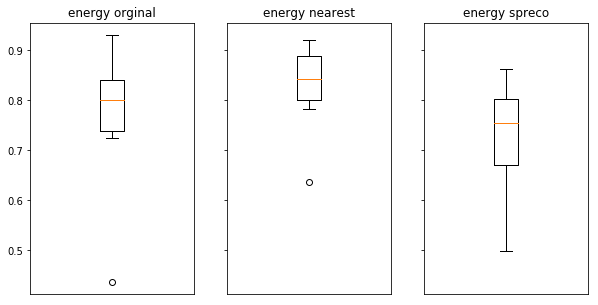

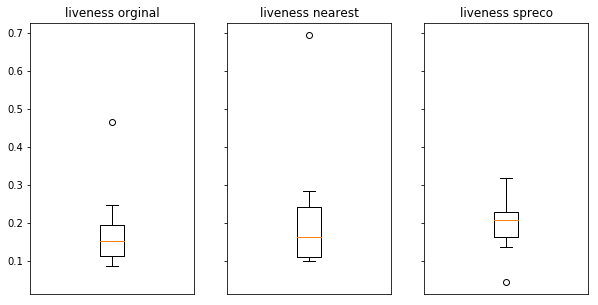

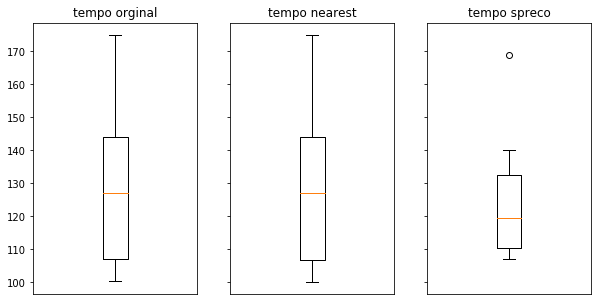

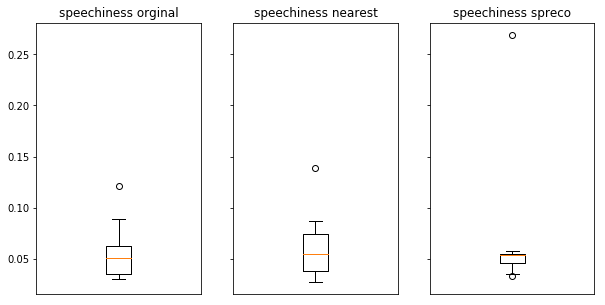

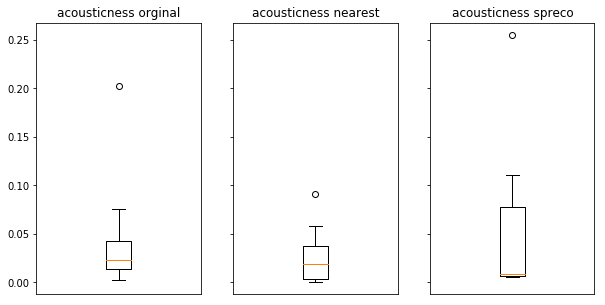

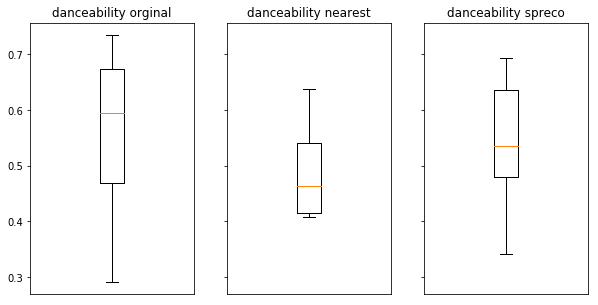

In [19]:
# compare playlist audio features
for kpi in lst_use:
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10,5), sharey=True)
    
    ax1.boxplot(df_analysis_original[kpi])
    ax1.set_title(kpi +' orginal')
    ax1.set_xticks([0])
    
    ax2.boxplot(df_analysis_nearest[kpi])
    ax2.set_title(kpi +' nearest')
    ax2.set_xticks([0])
    
    ax3.boxplot(df_analysis_spreco[kpi])
    ax3.set_title(kpi +' spreco')
    ax3.set_xticks([0])

### Store both new playlist in Spotify

In [20]:
# create Nearest playlist
user ='bramvcamp'
new_playlist_name = orginal_playlist_name+' - Nearest'
new_playlist = sp.user_playlist_create(user, name=new_playlist_name, public=False)
playlist_id = new_playlist.get('id')
sp.user_playlist_add_tracks(user, playlist_id, tracks=lst_nearest_tracks)

print "new playlist created:"
print new_playlist_name

new playlist created:
Indie Cindy - Nearest


In [21]:
# create Spreco playlist
user ='bramvcamp'
new_playlist_name = orginal_playlist_name+' - Spreco'
new_playlist = sp.user_playlist_create(user, name=new_playlist_name, public=False)
playlist_id = new_playlist.get('id')
sp.user_playlist_add_tracks(user, playlist_id, tracks=lst_spreco_tracks)

print "new playlist created:"
print new_playlist_name

new playlist created:
Indie Cindy - Spreco
